In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd 
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D,Activation

Number of images in the train set :  2831
Number of images in the test set :  910


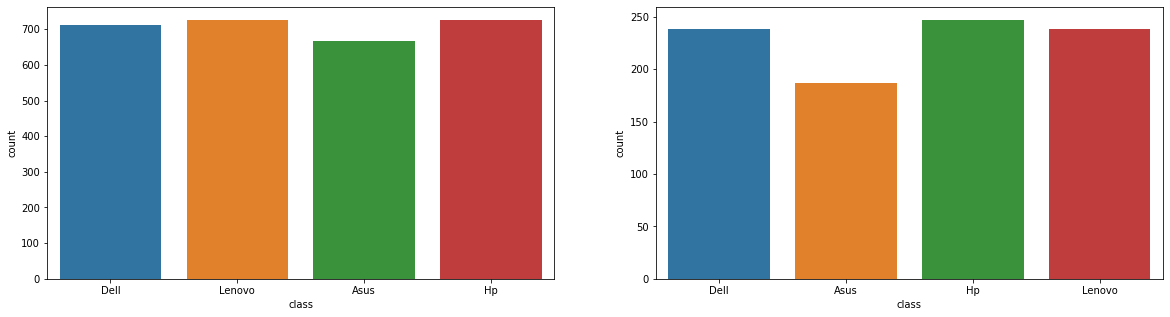

In [ ]:
root_path = '/content/drive/MyDrive/NewDataset'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/content/drive/MyDrive/NewDataset/train/'
test_folders = '/content/drive/MyDrive/NewDataset/valid/'
quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set : ",sum(quantity_te.values()))

plt.show()

In [ ]:
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
# def do_history_stuff(history, history_file_name, isinception=False):
#     save_history(history, history_file_name)
#     plot_accuracy_from_history(history, isinception)
#     plot_loss_from_history(history)

In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2,horizontal_flip=True, vertical_flip=True,rotation_range=1, width_shift_range=0.2,
                                                    height_shift_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(test_folders, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 2831 images belonging to 4 classes.
Found 910 images belonging to 4 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)

{'Asus': 0, 'Dell': 1, 'Hp': 2, 'Lenovo': 3}


In [ ]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

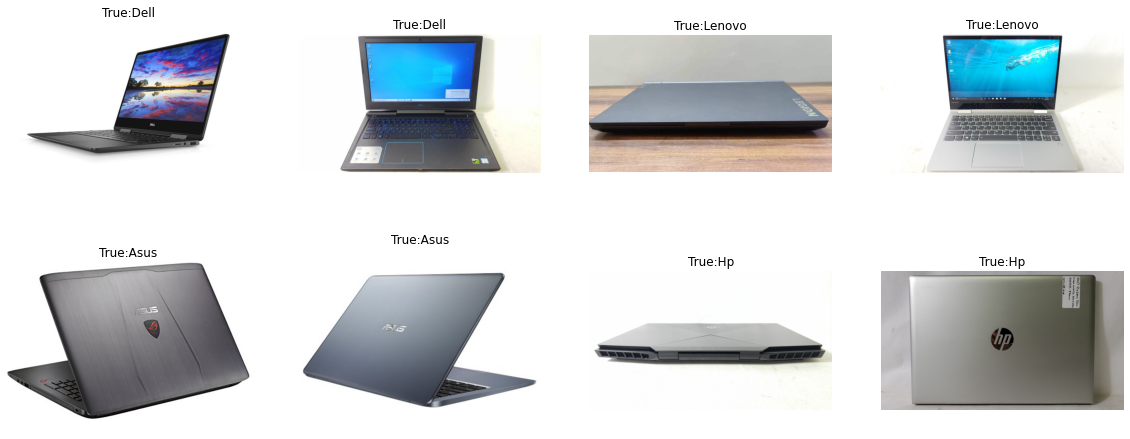

In [ ]:
show_few_images(2)

In [ ]:
tf.keras.backend.clear_session()

# epoch config
vgg_epoch = 15
resnet_epoch = 15
inception_epoch = 15

In [ ]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dropout(0.3)(vgg_x)
vgg_x = Dense(4, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)


58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/15
 8/89 [=>............................] - ETA: 56s - loss: 1.4342 - acc: 0.2852

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


89/89 [==============================] - 89s 964ms/step - loss: 1.3304 - acc: 0.3599 - val_loss: 1.3631 - val_acc: 0.3242

Epoch 00001: val_acc improved from -inf to 0.32418, saving model to vgg_16_-saved-model-01-acc-0.32.hdf5
Epoch 2/15
89/89 [==============================] - 87s 976ms/step - loss: 1.2178 - acc: 0.4564 - val_loss: 1.4458 - val_acc: 0.3253

Epoch 00002: val_acc improved from 0.32418 to 0.32527, saving model to vgg_16_-saved-model-02-acc-0.33.hdf5
Epoch 3/15
89/89 [==============================] - 85s 954ms/step - loss: 1.1798 - acc: 0.4779 - val_loss: 1.4664 - val_acc: 0.3242

Epoch 00003: val_acc did not improve from 0.32527
Epoch 4/15
89/89 [==============================] - 84s 951ms/step - loss: 1.1416 - acc: 0.5016 - val_loss: 1.3489 - val_acc: 0.3670

Epoch 00004: val_acc improved from 0.32527 to 0.36703, saving model to vgg_16_-saved-model-04-acc-0.37.hdf5
Epoch 5/15
89/89 [==============================] - 85s 959ms/step - loss: 1.1196 - acc: 0.5178 - val_lo

In [ ]:
vgg16_final_model.save("final_vgg16.h5")

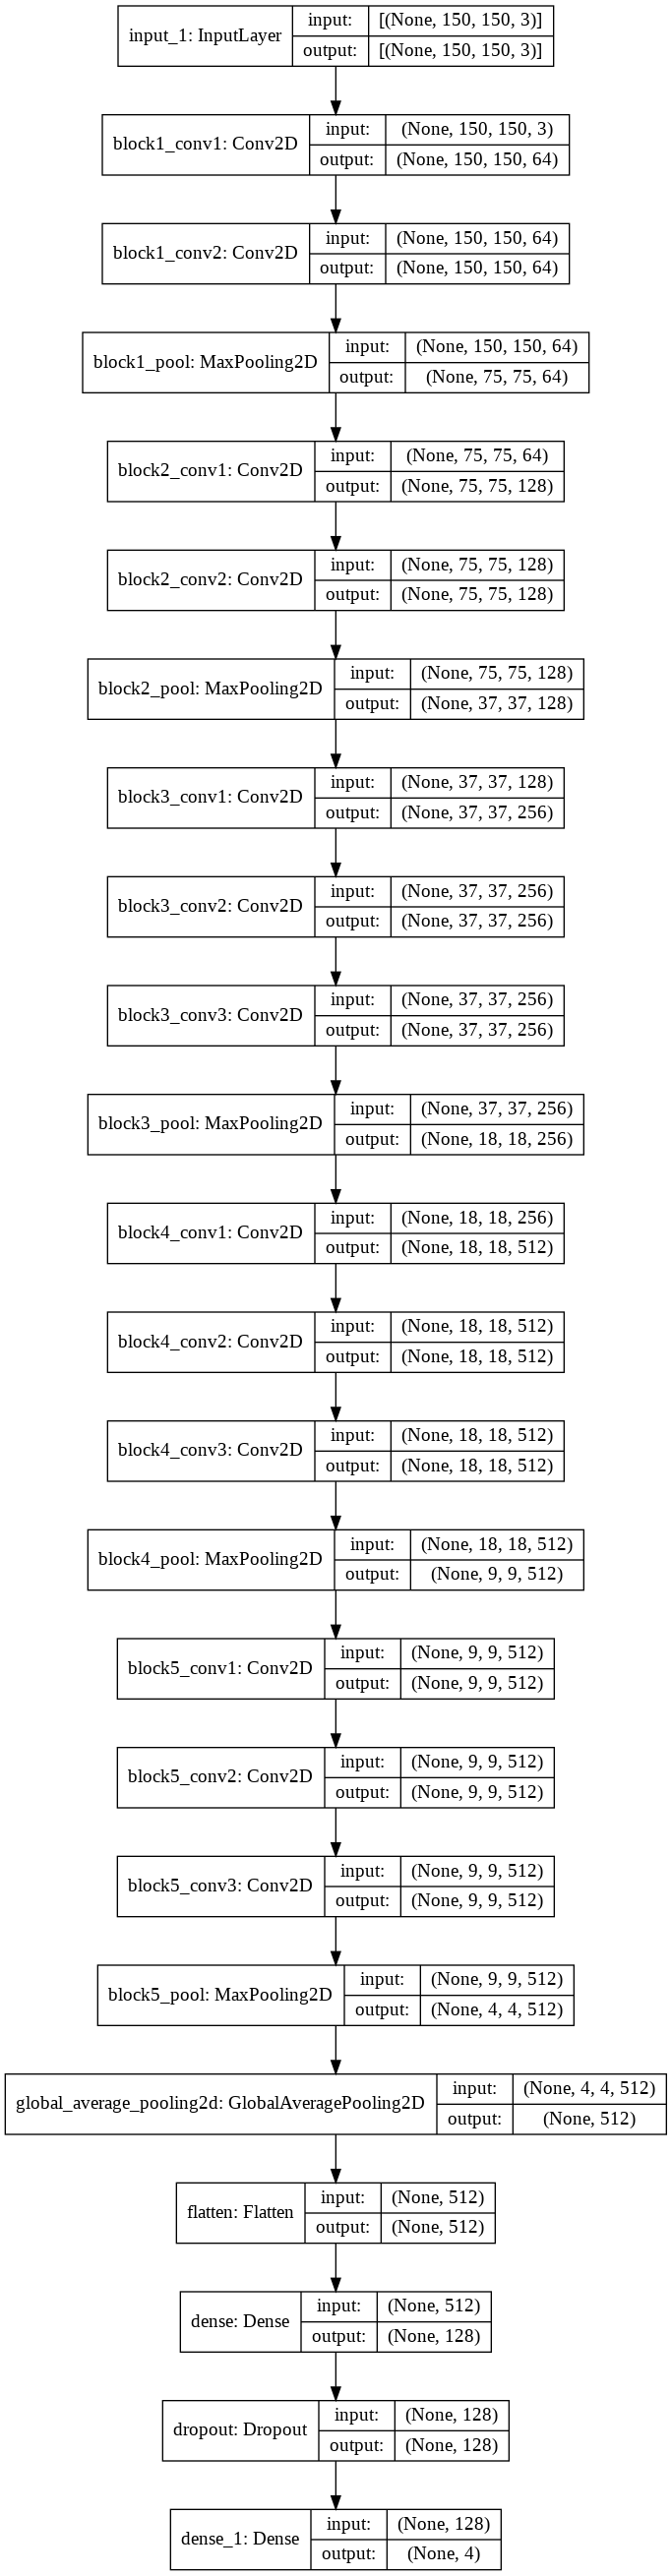

In [ ]:
plot_model(vgg16_final_model, to_file='vgg16model.png',show_shapes=True, show_layer_names=True)

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=4)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
resnet50_x = MaxPooling2D(pool_size=(2, 2))(resnet50_x)
resnet50_x = Flatten()(resnet50_x)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(4,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)


94773248/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


89/89 [==============================] - 1538s 17s/step - loss: 1.2602 - acc: 0.4348 - val_loss: 1.4726 - val_acc: 0.2615

Epoch 00001: val_acc improved from -inf to 0.26154, saving model to resnet50-saved-model-01-val_acc-0.26.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
89/89 [==============================] - 92s 1s/step - loss: 1.0543 - acc: 0.5394 - val_loss: 1.4886 - val_acc: 0.2615

Epoch 00002: val_acc did not improve from 0.26154
Epoch 3/15
89/89 [==============================] - 90s 1s/step - loss: 0.9497 - acc: 0.6023 - val_loss: 1.4277 - val_acc: 0.2604

Epoch 00003: val_acc did not improve from 0.26154
Epoch 4/15
89/89 [==============================] - 90s 1s/step - loss: 0.8943 - acc: 0.6344 - val_loss: 1.3701 - val_acc: 0.3132

Epoch 00004: val_acc improved from 0.26154 to 0.31319, saving model to resnet50-saved-model-04-val_acc-0.31.hdf5
Epoch 5/15
89/89 [==============================] - 90s 1s/step - loss: 0.8177 - acc: 0.6718 - val_loss: 1.4599 - val_acc: 0.2604

Epoch 00005: val_acc did not improve from 0.31319
Epoch 6/15
89/89 [==============================] - 90s 1s/step - loss: 0.7460 - acc: 0.7093 - val_loss: 1.5409 - val_acc: 0.2703

Epoch 00006: val_acc did not improve from 0.31319
Epoch 7/15
89/89 [==============

NameError: ignored

In [ ]:
resnet50_x_final_model.save("final_resnet.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# this could also be the output a different Keras model or layer

InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(4, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

# do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)  

87916544/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


89/89 [==============================] - 99s 1s/step - loss: 1.6677 - accuracy: 0.2967 - val_loss: 1.6093 - val_accuracy: 0.3132
Epoch 2/15
89/89 [==============================] - 92s 1s/step - loss: 1.3944 - accuracy: 0.3868 - val_loss: 1.4925 - val_accuracy: 0.3352
Epoch 3/15
89/89 [==============================] - 91s 1s/step - loss: 1.2878 - accuracy: 0.4422 - val_loss: 1.4543 - val_accuracy: 0.3516
Epoch 4/15
89/89 [==============================] - 91s 1s/step - loss: 1.2024 - accuracy: 0.4896 - val_loss: 1.4374 - val_accuracy: 0.3560
Epoch 5/15
89/89 [==============================] - 89s 1s/step - loss: 1.1959 - accuracy: 0.4875 - val_loss: 1.4175 - val_accuracy: 0.3813
Epoch 6/15
89/89 [==============================] - 93s 1s/step - loss: 1.1470 - accuracy: 0.5101 - val_loss: 1.4132 - val_accuracy: 0.3626
Epoch 7/15
89/89 [==============================] - 89s 1s/step - loss: 1.1021 - accuracy: 0.5256 - val_loss: 1.3954 - val_accuracy: 0.3736
Epoch 8/15
89/89 [=============

In [ ]:
InceptionV3_x_final_model.save("final_inceptionv3.hdf5")

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(
    train_generator,
    epochs = number_of_epochs, validation_data = validation_generator,verbose=1)

In [ ]:
model.save("custom.h5")

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

In [ ]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
for folder in os.listdir(test_folders):
    
    test_image_ids = os.listdir(os.path.join(test_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(test_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255

        #vgg
        vgg16_image_prediction = np.argmax(vgg16_final_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        
        #resnet50
        resnet_50_image_prediction = np.argmax(resnet50_x_final_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)
        
        #Inception
        inception_image_prediction = np.argmax(InceptionV3_x_final_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)
	        #giving vgg16 high priority if they all predict something different
        image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])                                  
        combined_model_pred.append(image_prediction)

Model Accuracy 0.38461538461538464
              precision    recall  f1-score   support

        Asus       0.34      0.62      0.44       187
        Dell       0.47      0.24      0.32       238
          Hp       0.42      0.21      0.28       247
      Lenovo       0.38      0.52      0.44       238

    accuracy                           0.38       910
   macro avg       0.40      0.40      0.37       910
weighted avg       0.41      0.38      0.37       910



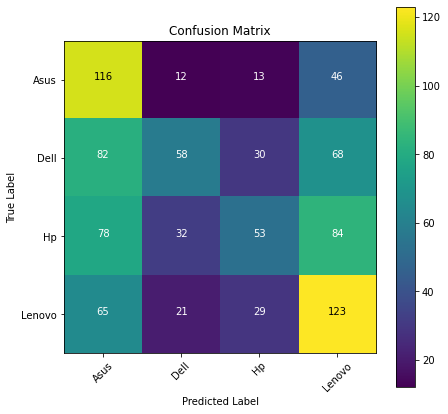

In [ ]:
# VGG model classification report
clf_report(true_value, vgg_pred)

Model Accuracy 0.5351648351648352
              precision    recall  f1-score   support

        Asus       0.43      0.78      0.56       187
        Dell       0.65      0.29      0.40       238
          Hp       0.61      0.47      0.53       247
      Lenovo       0.57      0.66      0.61       238

    accuracy                           0.54       910
   macro avg       0.56      0.55      0.52       910
weighted avg       0.57      0.54      0.52       910



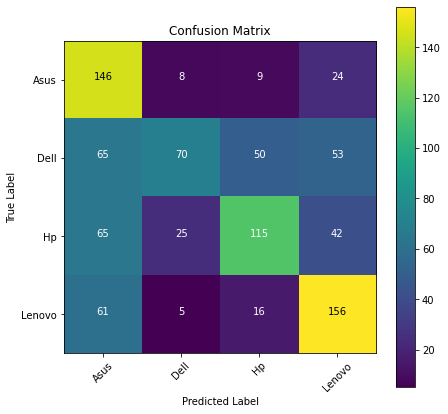

In [ ]:
# Resnet50 model classification report
clf_report(true_value, resnet_pred)

Model Accuracy 0.4032967032967033
              precision    recall  f1-score   support

        Asus       0.33      0.67      0.44       187
        Dell       0.59      0.11      0.19       238
          Hp       0.53      0.29      0.38       247
      Lenovo       0.41      0.60      0.49       238

    accuracy                           0.40       910
   macro avg       0.46      0.42      0.37       910
weighted avg       0.47      0.40      0.37       910



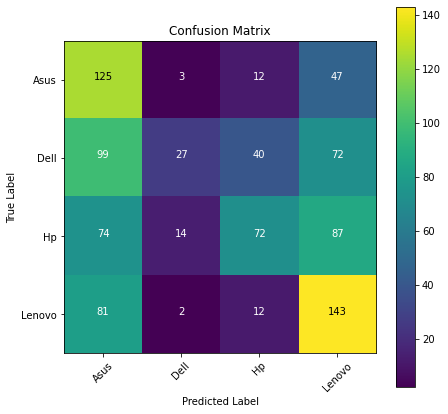

In [ ]:
# Inception model classification report
clf_report(true_value, inception_pred)